<a href="https://colab.research.google.com/github/furio1999/Computer-Vision/blob/main/Multimedia_Forensics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimedia forensics

Trustworthy multimedia content is important to a number of institutions in today’s society, including news outlets, courts of law, police investigations, intelligence agencies, and social media websites.

In this notebook, we implement a forensic tool decide whether an image is tampered or not. Moreover, we will discuss the accuracy of determining whether two image patches were captured by the same or different camera model.

# Loading data

In [ ]:
!rm -r *
!git clone https://gitlab.com/lucamaiano/vision-and-perception-forensics-tutorial.git
!mv vision-and-perception-forensics-tutorial/* .

!pip install cairocffi
!pip install python-igraph

Cloning into 'vision-and-perception-forensics-tutorial'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 158 (delta 83), reused 149 (delta 74), pack-reused 0
Receiving objects: 100% (158/158), 37.94 MiB | 35.00 MiB/s, done.
Resolving deltas: 100% (83/83), done.
     |████████████████████████████████| 71kB 4.9MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.2.0-cp37-none-any.whl size=89548 sha256=bcafbb336d1f76430c5c861703bde361e35a28dc5f8af9ffd5787c23c6e58e6b
  Stored in directory: /root/.cache/pip/wheels/40/76/48/f1effadceea83b32e7d957dd0f92db4db8b537d7b72b4ef374
Successfully built cairocffi
     |████████████████████████████████| 3.2MB 7.1MB/s 


In [ ]:
import numpy as np
import os
import igraph as ig
import PIL.Image
import seaborn as sns
import pickle

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, Concatenate, Multiply
from tensorflow.keras import layers
from tensorflow.keras import Model

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

from src.graph_utils import adj_to_graph, sym_mat
from src.simgraph import *
from src.utils import load_MISL_weights, load_SimilarityNet_weights, load_pretrained_weights
from src.blockimage import tile_image, span_image_by_overlap
import src.spectral_utils as su
import src.graph_utils as gu
import src.localization as localization

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)

Num GPUs Available:  1


In [ ]:
f1 = './testimages/normal-01.TIF' #authentic image
f2 = './testimages/splicing-01.TIF' #spliced image

patch_size = 256 #patch size, must match associated weights file
overlap = 0 #patch sampling overlap, usually this is set to 50% or 75% of the patch size 

weights_dict = load_pretrained_weights(patch_size)

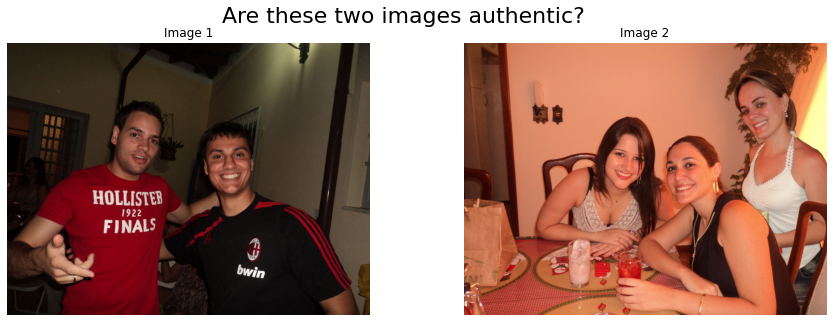

In [ ]:
#show both images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Are these two images authentic?', fontsize=22)

I1 = plt.imread(f1)[:,:,:3]
ax1.imshow(I1)
ax1.axis('off')
ax1.title.set_text('Image 1')

I2 = plt.imread(f2)[:,:,:3]
ax2.imshow(I2)
ax2.axis('off')
ax2.title.set_text('Image 2')

plt.show()

# Forensic similarity

> We define forensic similarity as the function $C: \mathbb{X} \times \mathbb{X} \to \{0, 1\}$ that compares two image patches. This is done by mapping two input image patches $X_1 , X_2 ∈ X$ to a score indicating whether the two image patches have the same or different forensic trace. A score of 0 indicates the two image patches contain different forensic traces, and a score of 1 indicates they contain the same forensic trace.

To construct this system, we construct a forensic similarity system consisting of two parts:


1.   The feature extractor $f: \mathbb{X} \to \mathbb{R}^N$ which maps an input image patch X to a real valued N- dimensional feature space. This feature space encodes high- level forensic information about the image patch $X$.

2.   The similarity function $S: \mathbb{R}^N \times \mathbb{R}^N \to [0,1]$ that maps pairs of forensic feature vectors to a *similarity score* that takes values from 0 to 1. A low similarity score indicates that the two image patches X1 and X2 have dissimilar forensic traces, and a high similarity score indicates that the two forensic traces are highly similar.

Finally, we compare the similarity score $S(f(X_1), f(X_2))$ of two image patches $X_1$ and $X_2$ to a threshold η such that

> $ C(X_1, X_2) =
  \begin{cases}
    0       & \quad \text{if } S(f(X_1), f(X_2)) \leq \eta \\
    1       & \quad \text{if } S(f(X_1), f(X_2)) > \eta
  \end{cases}
$


<p align="center"><img width="8000" src="https://omayer.gitlab.io/forensicsimilarity/img/tif_forensicsimilarity_architecture_6.jpg"></p>

# Model architecture

Let's begin by defining the forensic similarity network. The network is made by two parts: a feature extractor (namely `MISLNet`) and a similarity network called `SimilarityNet`.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, Concatenate, Multiply
from tensorflow.keras import layers
from tensorflow.keras import Model

class MISLNet(Model):
    def __init__(self, input_size=128, nprefilt=6):
        super(MISLNet, self).__init__()
        w_inititalizer = tf.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform")

        # CONV layers
        self.constrained = Conv2D(nprefilt, (5,5), kernel_initializer=w_inititalizer, use_bias=False, name="constrained", padding="valid")

        self.conv1 = Conv2D(96, (7,7), strides=(2,2), kernel_initializer=w_inititalizer, bias_initializer="zeros", name="conv1", padding="same")
        self.bn1 = BatchNormalization(axis=-1, center=True, scale=True, name="bn1")
        self.maxpool1 = MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='valid', name="maxpool1")

        self.conv2 = Conv2D(64, (5,5), kernel_initializer=w_inititalizer, bias_initializer="zeros", name="conv2", padding="same")
        self.bn2 = BatchNormalization(axis=-1, center=True, scale=True, name="bn2")
        self.maxpool2 = MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='valid', name="maxpool2")

        self.conv3 = Conv2D(64, (5,5), kernel_initializer=w_inititalizer, bias_initializer="zeros", name="conv3", padding="same")
        self.bn3 = BatchNormalization(axis=-1, center=True, scale=True, name="bn3")
        self.maxpool3 = MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='valid', name="maxpool3")

        self.conv4 = Conv2D(128, (1,1), kernel_initializer=w_inititalizer, bias_initializer="zeros", name="conv4", padding="same")
        self.bn4 = BatchNormalization(axis=-1, center=True, scale=True, name="bn4")
        self.maxpool4 = MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='valid', name="maxpool4")

        # FC layers
        self.reshape =  Flatten()
        # if input_size == 128:
        #     self.reshape = Reshape((-1, 2 * 2 * 128))
        # elif input_size == 256:
        #     self.reshape = Reshape((-1, 6 * 6 * 128))
        # else:
        #     raise TypeError('Unsupported patch size {}'.format(input_size))

        self.fc1 = Dense(200, kernel_initializer=w_inititalizer, bias_initializer="zeros", name="fc1")
        self.fc2 = Dense(200, kernel_initializer=w_inititalizer, bias_initializer="zeros", name="fc2")

    def call(self, x):
        x = self.constrained(x)

        # CONV layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = tf.nn.tanh(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = tf.nn.tanh(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = tf.nn.tanh(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = tf.nn.tanh(x)
        x = self.maxpool4(x)

        # FC layers
        x = self.reshape(x)
        x = self.fc1(x)
        x = tf.nn.tanh(x)
        x = self.fc2(x)
        x = tf.nn.tanh(x)

        return x

# Create an instance of the model
model = MISLNet()
# Try out
input_x = tf.random.uniform((1, 128, 128, 3))
y_hat = model(input_x)
model.summary()

Model: "misl_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
constrained (Conv2D)         multiple                  450       
_________________________________________________________________
conv1 (Conv2D)               multiple                  28320     
_________________________________________________________________
bn1 (BatchNormalization)     multiple                  384       
_________________________________________________________________
maxpool1 (MaxPooling2D)      multiple                  0         
_________________________________________________________________
conv2 (Conv2D)               multiple                  153664    
_________________________________________________________________
bn2 (BatchNormalization)     multiple                  256       
_________________________________________________________________
maxpool2 (MaxPooling2D)      multiple                  0  

## Converting Tensorflow 1.x code to Tensorflow 2.x

Here we wanto to convert the Similarity Network from Tensorflow 1.x to Tensorflow 2.x.

In [ ]:
def prefeat_CompareNet_v1(f1,f2,nb12=2048,nb3=64):
    # source: https://gitlab.com/omayer/forensic-graph/-/blob/master/src/mislnet_model.py
    # TF 1 implementation
    with tf.variable_scope('CompareNet') as scope:
        w_fcb1 = weight_variables(name="weights_fcb1", shape=[200, nb12])
        b_fcb1 = tf.get_variable(name='bias_fcb1', shape=[nb12], dtype=tf.float32, initializer=tf.constant_initializer(0))
        
        fcb1 = tf.nn.relu(tf.add(tf.matmul(f1, w_fcb1), b_fcb1),name='fcb1_out')
        fcb2 = tf.nn.relu(tf.add(tf.matmul(f2, w_fcb1), b_fcb1),name='fcb2_out')
		
        fcb1b2_mult = tf.multiply(fcb1,fcb2,name='fcb1b2_mult')
        fcb1b2_concat = tf.concat([fcb1,fcb1b2_mult,fcb2],1)  #print without mult: it should not to be able to detect similarity, where mult is used?-->in fcb3. Is relu fooled by absence of mult?

        w_fcb3 = weight_variables(name="weights_fcb3", shape=[nb12*3, nb3])
        b_fcb3 = tf.get_variable(name='bias_fcb3', shape=[nb3], dtype=tf.float32, initializer=tf.constant_initializer(0))
        fcb3 = tf.nn.relu(tf.add(tf.matmul(fcb1b2_concat, w_fcb3), b_fcb3),name='fcb3_out')

        w_out = weight_variables(name="weights_out", shape=[nb3, 2])
        b_out = tf.get_variable(name='bias_out', shape=[2], dtype=tf.float32, initializer=tf.constant_initializer(0))
        output = tf.matmul(fcb3, w_out) + b_out

    return output

In [ ]:
class SimilarityNet(Model):
    def __init__(self,  nb12=2048, nb3=64):
        super(SimilarityNet, self).__init__()
        w_inititalizer = tf.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform")

        # FC layers
        self.fc1 = Dense(nb12)

        self.multiply = Multiply()
        self.concat = Concatenate(axis=1)

        self.fc2 = Dense(nb3)
        self.fc3 = Dense(2)

    def call(self, f1, f2):
        # FC layers
        fcb1 = tf.nn.relu(self.fc1(f1))
        fcb2 = tf.nn.relu(self.fc1(f2))
        
        fcb1b2_mult = self.multiply([fcb1, fcb2])
        fcb1b2_concat = self.concat([fcb1, fcb1b2_mult, fcb2])
        
        fcb3 = tf.nn.relu(self.fc2(fcb1b2_concat))
        
        output = self.fc3(fcb3)
        
        return output

# Create an instance of the model
compare_model = SimilarityNet()

fc1 = tf.random.uniform((1, 200))
fc2 = tf.random.uniform((1, 200))
y_hat = compare_model(fc1, fc2)
compare_model.summary()

Model: "similarity_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  411648    
_________________________________________________________________
multiply (Multiply)          multiple                  0         
_________________________________________________________________
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  393280    
_________________________________________________________________
dense_2 (Dense)              multiple                  130       
Total params: 805,058
Trainable params: 805,058
Non-trainable params: 0
_________________________________________________________________


# Experiment 1: Image forgery detection

Now that we have our networks, we can import the pre-trained model and visualize the *forensic similarity graph* of authentic and tampered images.

Let's start with an authentic image first.

In [ ]:
import numpy as np
import os
import igraph as ig
import PIL.Image
import seaborn as sns
import pickle

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, Concatenate, Multiply
from tensorflow.keras import layers
from tensorflow.keras import Model

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

from src.graph_utils import adj_to_graph, sym_mat
from src.simgraph import *
from src.utils import load_MISL_weights, load_SimilarityNet_weights, load_pretrained_weights
from src.blockimage import tile_image, span_image_by_overlap
import src.spectral_utils as su
import src.graph_utils as gu
import src.localization as localization

In [ ]:
image_1 = plt.imread(f1)[:,:,:3]
similarity_graph_1 = calc_simgraph(image_1, patch_size, overlap, weights_dict, 
                                   batch_size=48, feature_batch=2056, verbose=False)

100%|██████████| 48/48 [00:00<00:00, 395.04it/s]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f208c118410>)

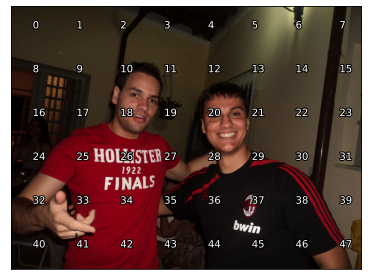

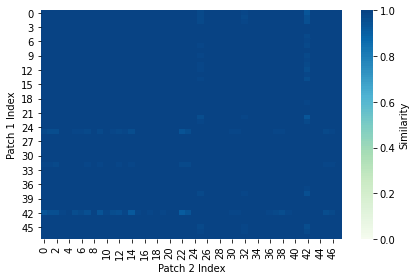

In [ ]:
 #plot index overlay for sampled patches
similarity_graph_1.plot_indices(image=I1)

#plot forensic similarity matrix, which will be used later for creating the graph
similarity_graph_1.plot_matrix()

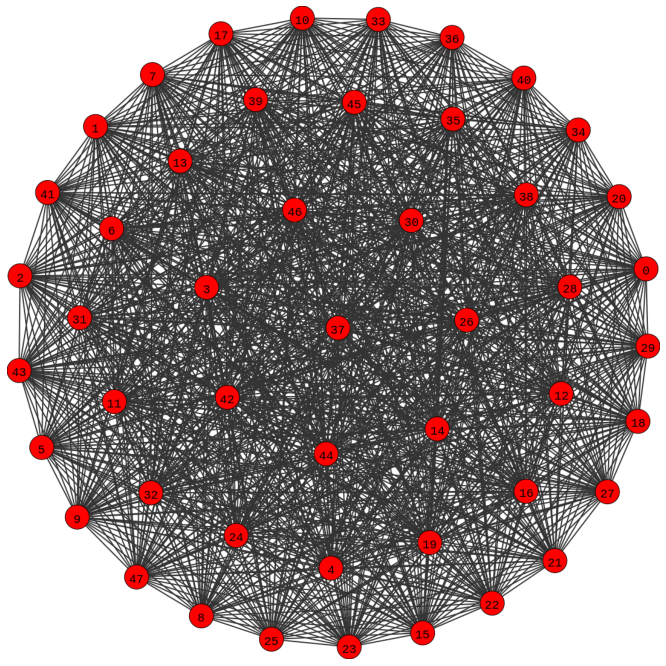

In [ ]:
M = sym_mat(similarity_graph_1.mat) #make the similarity matrix symmetric
np.fill_diagonal(M, 0) #set diagonals to zero (doesn't matter for calculations, just makes the plot look nicer)
g = adj_to_graph(M,threshold=0.9) #convert to igraph representation
c = g.community_fastgreedy(weights=g.es['weight']) #compute community structure

ig.plot(c.as_clustering(), 'temp_graph.png', bbox = (1080,1080), #plot it
        layout = 'kk', vertex_label_size=20, vertex_size=40, edge_width=2)

f,ax = plt.subplots(1,figsize=(12,12))
ax.imshow(plt.imread('temp_graph.png'))
ax.set_axis_off()
plt.show() 
#def of patch? what does the connections between patches represent?

From the graph, we cannot observe more than a cluster, suggesting that the image is consistent across all patches.

Now, we will run the same experiment on a new image, let's see what happens.

In [ ]:
#compute forensic similarity graphs for the spliced image
image_2 = plt.imread(f2)[:,:,:3]
tf.debugging.set_log_device_placement(True)
similarity_graph_2 = calc_simgraph(image_2, patch_size, overlap, weights_dict, 
                                  batch_size=48, feature_batch=2056, verbose=False)

In [ ]:
 #plot index overlay for sampled patches
similarity_graph_2.plot_indices(image=I2)

#plot forensic similarity matrix, which will be used later for creating the graph
similarity_graph_2.plot_matrix()

In [ ]:
M = sym_mat(similarity_graph_2.mat) #make the similarity matrix symmetric
np.fill_diagonal(M, 0) #set diagonals to zero (doesn't matter for calculations, just makes the plot look nicer)
g = adj_to_graph(M,threshold=0.9) #convert to igraph representation
c = g.community_fastgreedy(weights=g.es['weight']) #compute community structure

ig.plot(c.as_clustering(), 'temp_graph.png', bbox = (1080,1080), #plot it
        layout = 'kk', vertex_label_size=20, vertex_size=40, edge_width=2)

f,ax = plt.subplots(1,figsize=(12,12))
ax.imshow(plt.imread('temp_graph.png'))
ax.set_axis_off()
plt.show() 

From the forensic paper, let's look at two different clusters. This suggests that the image may have been manipulated. 

Now let's view the suspicious patches.

In [ ]:
M = gu.sym_mat(similarity_graph_2.mat) #symmetric similarity matrix for spliced image
g = gu.adj_to_graph(M, threshold=0.7) #convert to igraph Graph object

## Forgery Localization - Spectral Clustering
L = su.laplacian(M)
prediction = su.spectral_cluster(L)

pat_loc = localization.PatchLocalization(inds=similarity_graph_2.inds, patch_size=patch_size,
                                        prediction=prediction)

f = pat_loc.plot_heatmap(image=image_2,label=0)
#here we flip the label for easier visualization..
#note the label=0 in the line above (default=1)
#and the ~pat_loc.prediction in the line below
pix_loc = localization.pixel_loc_from_patch_pred(prediction=~pat_loc.prediction,
                                                 inds = similarity_graph_2.inds,
                                                 patch_size = patch_size,
                                                 image_shape = image_2.shape[:2],
                                                 threshold = 0.37)

pix_loc.plot(image=image_2)

# Experiment 2: Camera model similarity

In this experiment, we test the efficacy of forensic similarity for determining whether two image patches were captured by the same or different camera model. 

In [ ]:
#LOAD IMAGES
I0 = plt.imread('./testimages/0_google_pixel_1.jpg')
I1 = plt.imread('./testimages/1_google_pixel_1.jpg')
I2 = plt.imread('./testimages/2_asus_zenphone_laser.jpg')

#SHOW IMAGES
fig,ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(I0); ax[1].imshow(I1); ax[2].imshow(I2)
ax[0].set_title('Image 0'); ax[1].set_title('Image 1'); ax[2].set_title('Image 2')
plt.show()

In [ ]:
patch_size = 128
overlap = 96
weights_dict = load_pretrained_weights(patch_size)

sim_0_1 = calc_similarity(I0,I1,patch_size, overlap, weights_dict, span=False) #between tiles from image 0 and image 1
sim_0_2 = calc_similarity(I0,I2,patch_size, overlap, weights_dict, span=False) #between tiles from image 0 and image 2
sim_1_2 = calc_similarity(I1,I2,patch_size, overlap, weights_dict, span=False) #between tiles from image 1 and image 2

100%|██████████| 1000/1000 [00:03<00:00, 309.62it/s]


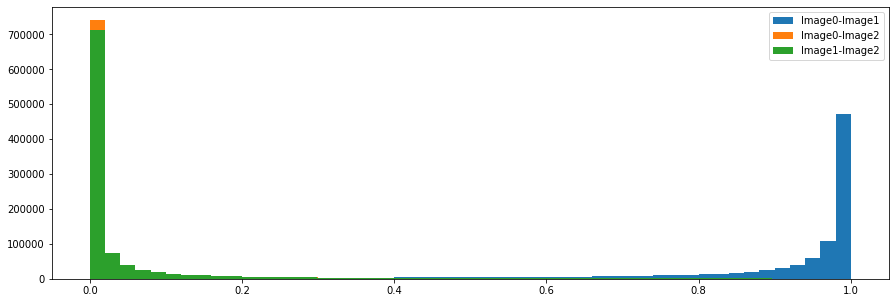

In [ ]:
 #plot distributions
fig,ax = plt.subplots(1, figsize=(15, 5))
ax.hist(sim_0_1,50,label='Image0-Image1')
ax.hist(sim_0_2,50,label='Image0-Image2')
ax.hist(sim_1_2,50,label='Image1-Image2')
ax.legend()
plt.show()

#image0 and image1 are from the same camera model, and have high forensic similarity
#image0 and image2 are from different camera models, and have low forensic similarity
#image1 and image2 are from different camera models, and have low forensic similarity

# Training the model

In the paper, the model is trained in two phases.
1.   **Learning Phase A - Feature Extractor**: we train the feature extractor network on a closed set of forensic traces referred to as “*known forensic traces*.” To do this, we add an *additional fully-connected layer* with softmax activationl to the feature extractor architecture. 

2.   **Learning Phase B - Similarity Network**: we train the similarity network to learn a forensic similarity mapping for any type of measurable forensic trace, such as whether two image patches were captured by the same or different camera model, or manipulated by the same or different editing operation. In this phase, we allow the error to back propagate through the feature extractor and update the feature extractor weights.

In this tutorial, we will experience a slight variation on a new forensic problem! We will train the MISL network to learn an *embedding* where authentic images are separated from GAN generated images. For the network to learn, we use a triplet loss function. You can find an introduction to triplet loss in the FaceNet paper by Schroff et al,. 2015. In this example, we define the triplet loss function as follows:

$L(A, P, N) = max(‖f(A) - f(P)‖^2 - ‖f(A) - f(N)‖^2 + margin, 0)$


## Generate and load data

Here, we generate a dataset of authentic and GAN generated human faces. The dataset will consist of real images (from CelebFaces Attributes Dataset - CelebA) and images generated by a GAN (see the paper on Progressive GANs).



In [ ]:
def generate_fake_images(num_images=2000, seed=42, latent_dim=512):
    # Generates fake images. Bsed on ProGAN.
    progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']
    fake_imgs = []
    tf.random.set_seed(seed)
    for img_i in tqdm(range(num_images), desc="Generating fake images..."):
        initial_vector = tf.random.normal([1, latent_dim])
        image = tf.constant(progan(initial_vector)['default'][0])
        image = tf.image.convert_image_dtype(image, tf.uint8)
        fake_imgs.append(image)

    fake_imgs = tf.convert_to_tensor(fake_imgs, dtype="uint8")
    
    return fake_imgs


def sample_authentic_images(num_images=2000, seed=42, name="celeb_a", data_dir="gs://celeb_a_dataset/", version='2.0.0'):
    # Samples authentic images from CelebA.
    celeb_a_builder = tfds.builder(name, data_dir=data_dir, version=version)
    celeb_a_builder.download_and_prepare()
    celeb_a_test_data = iter(celeb_a_builder.as_dataset(split='test').shuffle(seed).batch(num_images)).next()['image']
    auth_imgs = tf.image.resize_with_crop_or_pad(tf.convert_to_tensor(celeb_a_test_data), 128, 128)

    return auth_imgs


def display_image(image):
  # Simple way to display an image.
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  
  return PIL.Image.fromarray(image.numpy())


def save_images(saving_dir, img_list, c_name):
  for i, img in enumerate(img_list):
    img = display_image(img)
    img_filename = os.path.join(saving_dir, c_name + "_" + str(i) + ".jpg")
    img.save(img_filename)

def generate_dataset(num_images=1000, seed=32):
  total_images = num_images*2
  
  # Generate fake images
  fake_imgs = generate_fake_images(total_images, seed)
  # Download and sample authentic images
  auth_imgs = sample_authentic_images(total_images, seed)
  
  # output dirs
  left = "left"
  right = "right"

  if not os.path.isdir(left):
    os.makedirs(left)
  if not os.path.isdir(right):
    os.makedirs(right)
  
  assert len(fake_imgs) == len(auth_imgs)
  assert total_images % 2 == 0
  splits = int(total_images/2)

  fake_sim_1 = fake_imgs[:splits]
  fake_sim_2 = fake_imgs[splits:]

  auth_sim_1 = auth_imgs[:splits]
  auth_sim_2 = auth_imgs[splits:]


  save_images(left, auth_sim_1, "auth")
  save_images(left, fake_sim_1, "fake")

  save_images(right, auth_sim_2, "auth")
  save_images(right, fake_sim_2, "fake")


generate_dataset(num_images=1000, seed=42)

Generating fake images...: 100%|██████████| 2000/2000 [00:26<00:00, 74.73it/s]


Let's setup our data pipeline using a zipped list with an anchor, positive, and negative image filename as the source. The output of the pipeline contains the same triplet with every image loaded and preprocessed.

In [ ]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


patch_size=128
target_shape = (patch_size, patch_size)

anchor_images_path = "left"
positive_images_path = "right"

# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = sorted(
    [str(os.path.join(anchor_images_path, f)) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(os.path.join(positive_images_path, f)) for f in os.listdir(positive_images_path)]
)

negative_images = sorted(
    [str(os.path.join(positive_images_path, f)) for f in os.listdir(positive_images_path)], reverse=True
)


image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)
rng.shuffle(negative_images)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=4096)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

Let's take a look at a few examples of triplets. Notice how the first two images look alike while the third one is always different.

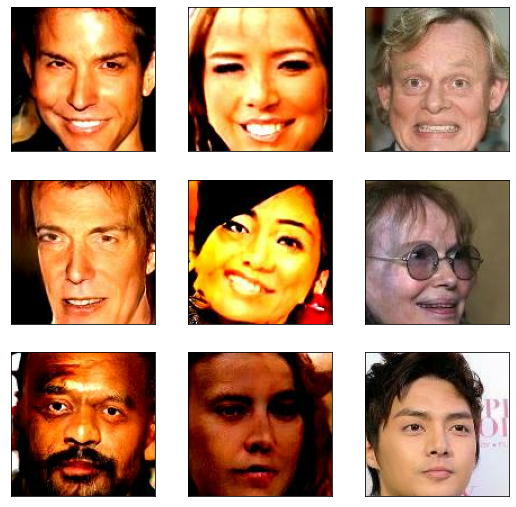

In [ ]:
visualize(*list(train_dataset.take(4).as_numpy_iterator())[0])

## Setting up the embedding generator model

Our Siamese Network will generate embeddings for each of the images of the triplet. To do this, we will use thr MISL model.

In [ ]:
img_inputs = tf.keras.Input(shape=(patch_size, patch_size, 3))
x = Conv2D(6, (5,5), use_bias=False, name="constrained", padding="valid")(img_inputs)

x = Conv2D(96, (7,7), strides=(2,2), activation="tanh", name="conv1", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='valid', name="maxpool1")(x)

x = Conv2D(64, (5,5), name="conv2",  activation="tanh", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='valid', name="maxpool2")(x)

x = Conv2D(64, (5,5), name="conv3",  activation="tanh", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='valid', name="maxpool3")(x)

x = Conv2D(128, (1,1), name="conv4",  activation="tanh", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='valid', name="maxpool4")(x)

x = Flatten()(x)
x = Dense(200, activation="tanh")(x)
outputs = Dense(200)(x)

embedding = Model(inputs=img_inputs, outputs=outputs, name="Embedding")

## Setting up the Siamese Network model

The Siamese network will receive each of the triplet images as an input, generate the embeddings, and output the distance between the anchor and the positive embedding, as well as the distance between the anchor and the negative embedding.

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1) # ‖f(A) - f(P)‖²
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1) # ‖f(A) - f(N)‖²
        
        return (ap_distance, an_distance)


anchor_input = tf.keras.Input(name="anchor", shape=target_shape + (3,))
positive_input = tf.keras.Input(name="positive", shape=target_shape + (3,))
negative_input = tf.keras.Input(name="negative", shape=target_shape + (3,))


distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

## Putting everything together
We now need to implement a model with custom training loop so we can compute the triplet loss using the three embeddings produced by the Siamese network.

Let's create a Mean metric instance to track the loss of the training process.

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

## Training

We are now ready to train our model.


In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
50/50 [==============================] - 10s 150ms/step - loss: 0.1271 - val_loss: 0.0376
Epoch 2/10
50/50 [==============================] - 7s 132ms/step - loss: 0.0334 - val_loss: 0.0160
Epoch 3/10
50/50 [==============================] - 7s 132ms/step - loss: 0.0134 - val_loss: 0.0086
Epoch 4/10
50/50 [==============================] - 7s 133ms/step - loss: 0.0110 - val_loss: 0.0085
Epoch 5/10
50/50 [==============================] - 7s 134ms/step - loss: 0.0067 - val_loss: 0.0012
Epoch 6/10
50/50 [==============================] - 7s 132ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 7/10
50/50 [==============================] - 7s 132ms/step - loss: 0.0016 - val_loss: 0.0000e+00
Epoch 8/10
50/50 [==============================] - 7s 131ms/step - loss: 9.8405e-04 - val_loss: 0.0000e+00
Epoch 9/10
50/50 [==============================] - 7s 131ms/step - loss: 0.0026 - val_loss: 6.2361e-04
Epoch 10/10
50/50 [==============================] - 7s 131ms/step - loss: 0.0076 -

## Inspecting what the network has learned

At this point, we can check how the network learned to separate the embeddings depending on whether they belong to similar images.

We can use [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) to measure the similarity between embeddings.

Let's pick a sample from the dataset to check the similarity between the embeddings generated for each image.

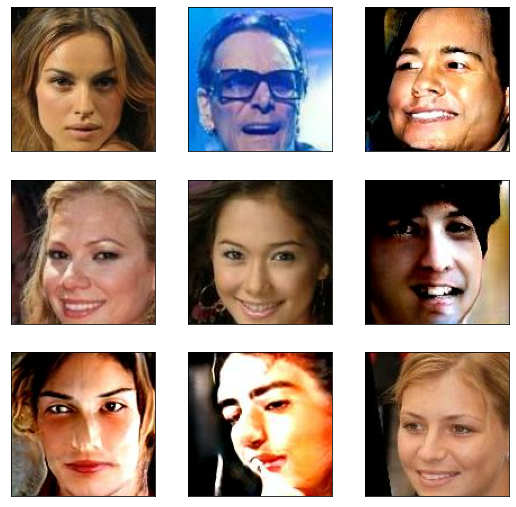

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(anchor),
    embedding(positive),
    embedding(negative),
)

Finally, we can compute the cosine similarity between the anchor and positive images and compare it with the similarity between the anchor and the negative images.

We should expect the similarity between the anchor and positive images to be larger than the similarity between the anchor and the negative images.

In [ ]:
cosine_similarity = tf.keras.metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9271101
Negative similarity 0.8085905


# References


1.   Mayer, Owen and Stamm, Matthew C, Forensic Similarity for Digital Images, IEEE Transactions on Information Forensics and Security 2019 (https://gitlab.com/MISLgit/forensic-similarity-for-digital-images/)
2.   Mayer, Owen and Stamm, Matthew C, Exposing Fake Images With Forensic Similarity Graphs, IEEE Journal of Selected Topics in Signal Processing 2020 (http://omayer.gitlab.io/forensicsimilarity/forensicgraph/)
3.   Schroff et al., FaceNet: A unified embedding for face recognition and clustering, 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR)
4.   Siamese networks: https://keras.io/examples/vision/siamese_network/
5.   Generate Artificial Faces with CelebA Progressive GAN Model: https://www.tensorflow.org/hub/tutorials/tf_hub_generative_image_module

     

